<a href="https://colab.research.google.com/github/ShinAsakawa/2019cnps/blob/master/notebooks/2019cnps_sketch_RNN_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 書画の RNN デモ

Python 2.7 required!

<!--In this notebook, we will show how to load pre-trained models and draw things with sketch-rnn-->

In [0]:
# Sketch_RNN is required to run on python 2.7!
# import the required libraries
import numpy as np
import time
import random
import cPickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange

In [0]:
# libraries required for visualisation:
from IPython.display import SVG, display
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

In [0]:
#!conda install -c omnia svgwrite=1.1.6
!pip install svgwrite==1.1.6
import svgwrite 

In [0]:
tf.logging.info("TensorFlow Version: %s", tf.__version__)

In [0]:
# import our command line tools
from magenta.models.sketch_rnn.sketch_rnn_train import *
from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *

W0815 08:14:03.359262 140345665382272 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/magenta/pipelines/statistics.py:131: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.

W0815 08:14:06.885198 140345665382272 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/magenta/music/note_sequence_io.py:60: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

W0815 08:14:08.676728 140345665382272 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0815 08:14:08.678932 140345665382272 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-p

In [0]:
# little function that displays vector images and saves them to .svg
#def draw_strokes(data, factor=0.2, svg_filename = '/tmp/sketch_rnn/svg/sample.svg'):
def draw_strokes(data, 
                 factor=0.2, 
                 svg_filename='/Users/asakawa/study/2018cnps/jupyter-notebooks/tmp/sketch_rnn/svg/sample.svg'):
  tf.gfile.MakeDirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in xrange(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

# まずは「ヒツジ」を描かせてみる

In [0]:
data_dir = 'http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/'
models_root_dir = '/Users/asakawa/study/2018tensorflow_magenta-demos.git/jupyter-notebooks/sketch_rnn/models'
model_dir = '/Users/asakawa/study/2018tensorflow_magenta-demos.git/jupyter-notebooks/sketch_rnn/models/aaron_sheep/layer_norm'

In [0]:
download_pretrained_models(models_root_dir=models_root_dir)

W0815 08:14:21.414820 140345665382272 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/magenta/models/sketch_rnn/sketch_rnn_train.py:98: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.

I0815 08:14:21.424583 140345665382272 sketch_rnn_train.py:105] Downloading pretrained models from http://download.magenta.tensorflow.org/models/sketch_rnn.zip...
I0815 08:14:23.171777 140345665382272 sketch_rnn_train.py:107] Download complete.
I0815 08:14:23.173125 140345665382272 sketch_rnn_train.py:108] Unzipping /Users/asakawa/study/2018tensorflow_magenta-demos.git/jupyter-notebooks/sketch_rnn/models/sketch_rnn.zip...
I0815 08:14:25.269222 140345665382272 sketch_rnn_train.py:111] Unzipping complete.


In [0]:
def load_env_compatible(data_dir, model_dir):
  """Loads environment for inference mode, used in jupyter notebook."""
  # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
  # to work with depreciated tf.HParams functionality
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    data = json.load(f)
  fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
  for fix in fix_list:
    data[fix] = (data[fix] == 1)
  model_params.parse_json(json.dumps(data))
  return load_dataset(data_dir, model_params, inference_mode=True)

def load_model_compatible(model_dir):
  """Loads model for inference mode, used in jupyter notebook."""
  # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
  # to work with depreciated tf.HParams functionality
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    data = json.load(f)
  fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
  for fix in fix_list:
    data[fix] = (data[fix] == 1)
  model_params.parse_json(json.dumps(data))

  model_params.batch_size = 1  # only sample one at a time
  eval_model_params = sketch_rnn_model.copy_hparams(model_params)
  eval_model_params.use_input_dropout = 0
  eval_model_params.use_recurrent_dropout = 0
  eval_model_params.use_output_dropout = 0
  eval_model_params.is_training = 0
  sample_model_params = sketch_rnn_model.copy_hparams(eval_model_params)
  sample_model_params.max_seq_len = 1  # sample one point at a time
  return [model_params, eval_model_params, sample_model_params]

In [0]:
[train_set, 
 valid_set, 
 test_set, 
 hps_model, 
 eval_hps_model, 
 sample_hps_model] = load_env_compatible(data_dir, model_dir)

I0815 08:14:35.243695 140345665382272 sketch_rnn_train.py:133] Downloading http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/aaron_sheep.npz


ValueError: ignored

In [0]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

W0815 08:15:11.793584 140345665382272 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/magenta/models/sketch_rnn/sketch_rnn_train.py:63: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0815 08:15:11.795841 140345665382272 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/magenta/models/sketch_rnn/sketch_rnn_train.py:66: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.



NameError: ignored

In [0]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [0]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

W0815 08:15:15.824089 140345665382272 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/magenta/models/sketch_rnn/sketch_rnn_train.py:240: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.

W0815 08:15:15.825531 140345665382272 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/magenta/models/sketch_rnn/sketch_rnn_train.py:240: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



ValueError: ignored

<!--- We define two convenience functions to encode a stroke into a latent vector, and decode from latent vector to stroke.--->

# 動画表象の符号化関数の定義

In [0]:
def encode(input_strokes):
  strokes = to_big_strokes(input_strokes).tolist()
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  draw_strokes(to_normal_strokes(np.array(strokes)))
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]

# 動画表象の復号化関数の定義

In [0]:
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor)
  return strokes

# では，実際に描いてみる

In [0]:
# get a sample drawing from the test set, and render it to .svg
stroke = test_set.random_sample()
draw_strokes(stroke)

NameError: ignored

<!--- Let's try to encode the sample stroke into latent vector $z$-->

# 潜在空間上の変数 $z$ を連続的に変化させてみる

In [0]:
z = encode(stroke)

NameError: ignored

In [0]:
_ = decode(z, temperature=0.8) # convert z back to drawing at temperature of 0.8

NameError: ignored

Create generated grid at various temperatures from 0.1 to 1.0

In [0]:
stroke_list = []
for i in range(10):
  stroke_list.append([decode(z, draw_mode=False, temperature=0.1*i+0.1), [0, i]])
stroke_grid = make_grid_svg(stroke_list)
draw_strokes(stroke_grid)

NameError: ignored

<!--- Latent Space Interpolation Example between $z_0$ and $z_1$--->

# 潜在変数 $z_0$ から $z_1$ の間の線形内挿

In [0]:
# get a sample drawing from the test set, and render it to .svg
z0 = z
_ = decode(z0)

NameError: ignored

In [0]:
stroke = test_set.random_sample()
z1 = encode(stroke)
_ = decode(z1)

NameError: ignored

<!--- Now we interpolate between sheep $z_0$ and sheep $z_1$ --->

# 上の2つの間を内挿してみると

In [0]:
z_list = [] # interpolate spherically between z0 and z1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z0, z1, t))

NameError: ignored

In [0]:
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False), [0, i]])

IndexError: ignored

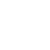

In [0]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

<!-- Let's load the Flamingo Model, and try Unconditional (Decoder-Only) Generation-->

# 別の画像を使ってみる

In [0]:
model_dir = '/tmp/sketch_rnn/models/flamingo/lstm_uncond'
model_dir = '/Users/asakawa/study/2018tensorflow_magenta-demos.git/jupyter-notebooks/sketch_rnn/models/flamingo/lstm_uncond'

In [0]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)

In [0]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

In [0]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [0]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

In [0]:
# randomly unconditionally generate 10 examples
N = 10
reconstructions = []
for i in range(N):
  #reconstructions.append([decode(temperature=0.5, draw_mode=False), [0, i]])
  reconstructions.append([decode(temperature=0.1, draw_mode=False), [0, i]])

In [0]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

<!--- Let's load the owl model, and generate two sketches using two random IID gaussian latent vectors-->

# フクロウと別の画像との融合

In [0]:
model_dir = '/tmp/sketch_rnn/models/owl/lstm'
model_dir = '/Users/asakawa/study/2018tensorflow_magenta-demos.git/jupyter-notebooks/sketch_rnn/models/owl/lstm'

In [0]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

In [0]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

In [0]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

Let's interpolate between the two owls $z_0$ and $z_1$

In [0]:
z_list = [] # interpolate spherically between z_0 and z_1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_0, z_1, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.1), [0, i]])

In [0]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

<!--Let's load the model trained on both cats and buses!  catbus!-->

# ネコとバスの画像の融合 インスパイアードバイ ジブリ lol

In [0]:
model_dir = '/tmp/sketch_rnn/models/catbus/lstm'
model_dir = '/Users/asakawa/study/2018tensorflow_magenta-demos.git/jupyter-notebooks/sketch_rnn/models/catbus/lstm'

In [0]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

# ネコ画像

In [0]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

In [0]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

<!-- Let's interpolate between a cat and a bus!!!-->

# ではやってみよう

In [0]:
z_list = [] # interpolate spherically between z_1 and z_0
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_1, z_0, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.15), [0, i]])

In [0]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

<!-- Why stop here? Let's load the model trained on both elephants and pigs!!!-->

In [0]:
model_dir = '/tmp/sketch_rnn/models/elephantpig/lstm'
model_dir = '/Users/asakawa/study/2018tensorflow_magenta-demos.git/jupyter-notebooks/sketch_rnn/models/elephantpig/lstm'

In [0]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

In [0]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

In [0]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

<!-- Tribute to an episode of [South Park](https://en.wikipedia.org/wiki/An_Elephant_Makes_Love_to_a_Pig): The interpolation between an Elephant and a Pig-->

# 「サウスパーク」の `An_Elephant_Makes_Love_to_a_Pig` を使って...

In [0]:
z_list = [] # interpolate spherically between z_1 and z_0
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_0, z_1, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  #reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.15), [0, i]])
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.5), [0, i]])